# Forecasting Energy Consumption in the Philippines Using Machine Learning Algorithms

## Erru Torculas, Earl James Rentillo

### CMSC 197: Machine Learning Mini-Project 
***

## Table of Contents
* [Preprocessing](#preprocess)
    * [Import Libraries](#import)
    * [Load Energy Consumption Dataset](#load)
    * [Data Cleaning](#clean)
    * [Splitting Dataset](#split)
    * [Dividing the Dataset into Training and Testing](#divide)
    * [Fitting the Model on the Training Set](#fitTrain)
        * [Required Functions](#require)
        * [Fit the Model](#fit)
        * [Predicting Quantitative Response y on Train and Test Set](#predict)
        * [Calculating the Cost of y for Train and Test Set](#calculate)
        
* [Questions](#questions)
    * [1. Optimal Weights Found in the Gradient Descent Implementation](#q1)
    * [2.1 Scatter Plot of $\hat{y^{(i)}}$ and $y^{(i)}$ for Train Set](#q21)
    * [2.2 Scatter Plot of $\hat{y^{(i)}}$ and $y^{(i)}$ for Test Set ](#q22)
    * [3. Effect on  Error, R2, and Cost as the Number of Iterations Increases](#q3)
    * [4. Effect on the Cost and Error as the Learning Rate Changes](#q4)
    * [5. Relationship on the Learning Rate and the Number of Iterations](#q5)
    * [6. Results Comparison with Least Squares Function](#q6)
    
***

## Preprocessing
***

### Importing Libraries

In [7]:
#### STANDARD LIBRARIES ####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### MACHINE LEARNING ALGORITHMS ####
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

#### METRICS OF EVALUATION ####
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Load Energy Consumption Dataset

In [8]:
df = pd.read_csv('energy-dataset/energyconsumption.csv', index_col = 0)
df

,Year,Month,Date,Total Energy Consumption (in GWh),Total Energy Consumption of CC by Industry Type (in GWh),Load Factor (in %),Quarterly Energy Consumption
1,2014,Jan,1/1/14,4422,NaN,84.0,NaN
2,2014,Feb,2/1/14,4690,NaN,87.0,NaN
3,2014,Mar,3/1/14,4485,NaN,90.0,13597
4,2014,Apr,4/1/14,5249,NaN,84.0,NaN
5,2014,May,5/1/14,5527,NaN,88.0,NaN
...,...,...,...,...,...,...,...
98,2022,Feb,2/1/22,6613,1776.0,82.0,NaN
99,2022,Mar,3/1/22,6354,1671.0,80.0,19365
100,2022,Apr,4/1/22,7727,1782.0,77.0,NaN
101,2022,May,5/1/22,7418,1828.0,80.0,NaN


### Data Cleaning

In [9]:
# Drop the irrelevant column that will not be used in analyses
dataDrop = ['Year', 'Month', 'Total Energy Consumption of CC by Industry Type (in GWh)', 'Load Factor (in %)', 'Quarterly Energy Consumption']
df = df.drop(dataDrop, axis=1)

# Make the Date as the index
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

df

,Total Energy Consumption (in GWh)
Date,
2014-01-01,4422
2014-02-01,4690
2014-03-01,4485
2014-04-01,5249
2014-05-01,5527
...,...
2022-02-01,6613
2022-03-01,6354
2022-04-01,7727


<AxesSubplot:xlabel='Date'>

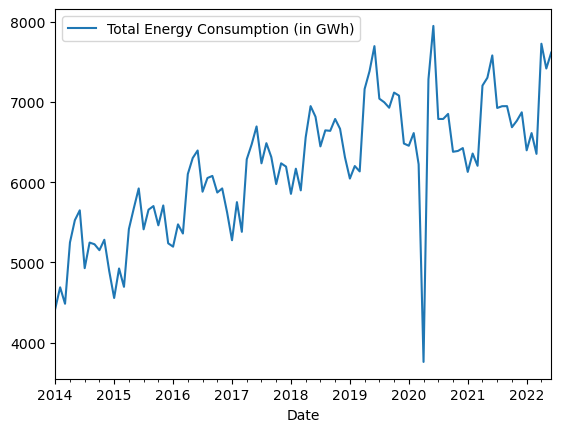

In [10]:
df.plot()

### Splitting Dataset

In [11]:
"""
Period 1: Pre-pandemic

TRAIN data = January 2014 - Jun 2018
TEST  data = July 2018 - March 2020 

"""
trainPre = df.loc[df.index <= '2018-06-01']
testPre = df.loc[(df.index > '2018-05-01') & (df.index <= '2020-03-01')]   # PLEASE CHECK
totalPre = df.loc[df.index <= '2020-03-01']

"""
Period 2: Pandemic

TRAIN data = January 2014 - March 2020
TEST  data = April 2018 - June 2022 

"""

trainPan = df.loc[df.index <= '2020-03-01'] 
testPan = df.loc[(df.index > '2020-02-01') & (df.index <= '2022-06-01')]
totalPan = df.loc[df.index <= '2022-06-01']

#### Test and Training Set Graphs

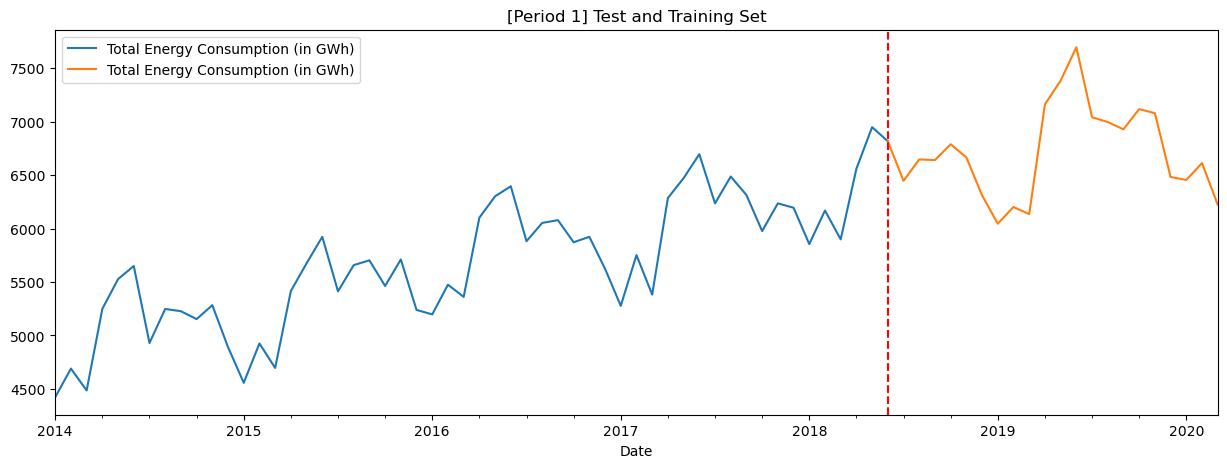

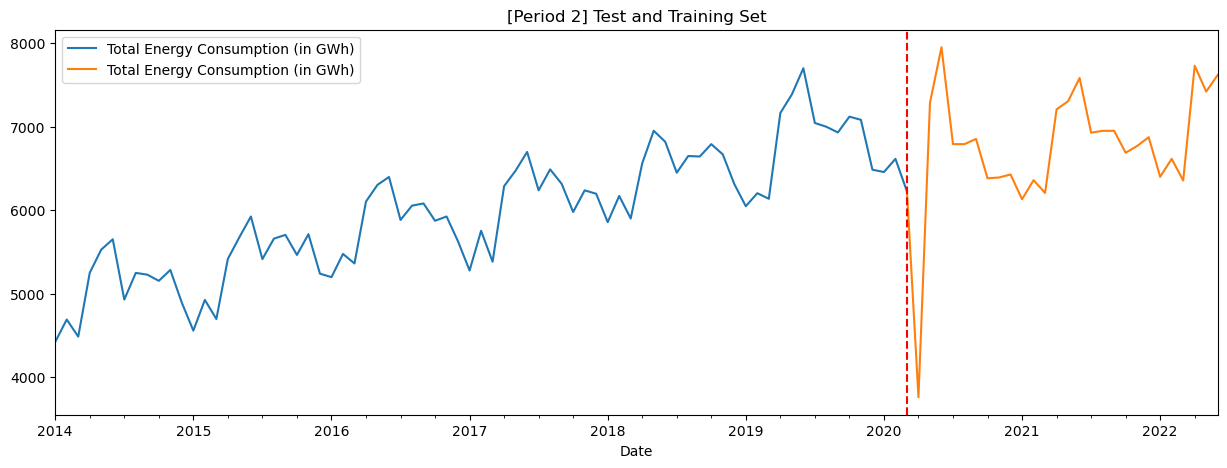

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
trainPre.plot(ax=ax, label="Training Set")
testPre.plot(ax=ax, label="Test Set")
ax.axvline('2018-06-01', color='red', ls='--')

plt.title("[Period 1] Test and Training Set")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
trainPan.plot(ax=ax, label="Training Set")
testPan.plot(ax=ax, label="Test Set")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 2] Test and Training Set")
plt.show()

### Create Features

In [13]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df = df.copy()
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day of Year'] = df.index.dayofyear
    return df

df = create_features(df)

In [14]:
FEATURES = ['Quarter', 'Month', 'Year', 'Day of Year']
TARGET = ['Total Energy Consumption (in GWh)']

#### Period 1: Create Features for Train and Test Data

In [15]:
trainPre = create_features(trainPre)
testPre = create_features(testPre)

##### Initialize Training and Testing Data

In [16]:
X_trainPre = trainPre[FEATURES]
y_trainPre = trainPre[TARGET]

X_testPre = testPre[FEATURES]
y_testPre = testPre[TARGET]

#### Create Features for Train and Test Data

In [17]:
trainPan = create_features(trainPan)
testPan = create_features(testPan)

##### Initialize Training and Testing Data

In [18]:
X_trainPan = trainPan[FEATURES]
y_trainPan = trainPan[TARGET]

X_testPan = testPan[FEATURES]
y_testPan = testPan[TARGET]

***
## Implementation of Machine Learning Algorithms
***

## Random Forest (RF) Model
***

In [33]:
randomForestModel = RandomForestRegressor(n_estimators=10000, max_features=4, random_state=1)

***
### PERIOD 1: Pre-Pandemic
***

#### Model Fitting

In [34]:
randomForestModel.fit(X_trainPre, y_trainPre)

/var/folders/s9/xh4rrhqs4pz887k97zl69jw00000gn/T/ipykernel_34917/997050837.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForestModel.fit(X_trainPre, y_trainPre)


RandomForestRegressor(max_features=4, n_estimators=10000, random_state=1)

#### Predictions

In [35]:
predRandomForest_pre = randomForestModel.predict(X_testPre)

# Make a new column in test dataframe: predictions for period 1
testPre["[Period 1] RF Predictions"] = predRandomForest_pre

#### Data Visualization

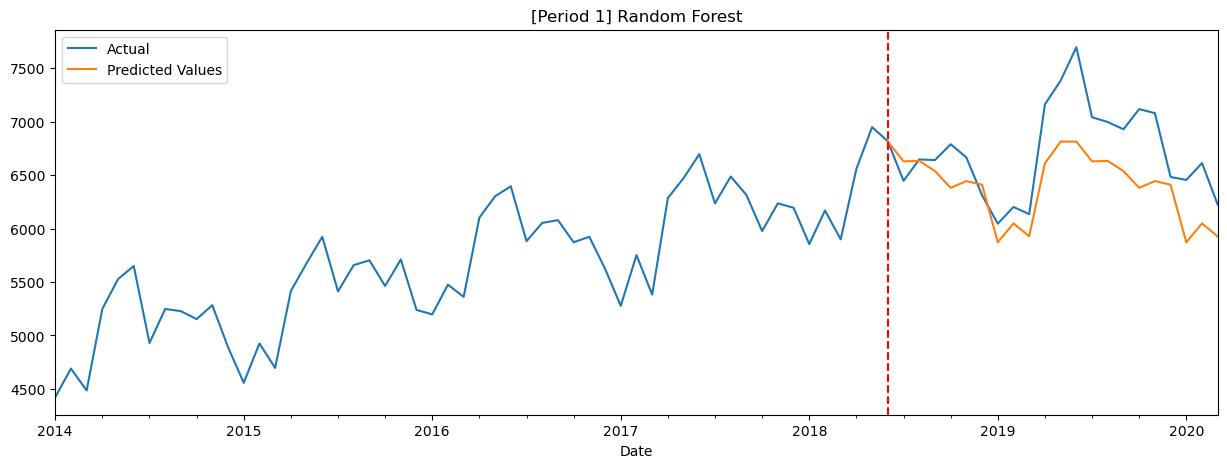

In [36]:
ax = totalPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] RF Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2018-06-01', color='red', ls='--')

plt.title("[Period 1] Random Forest")
plt.legend(loc="upper left")

plt.show()

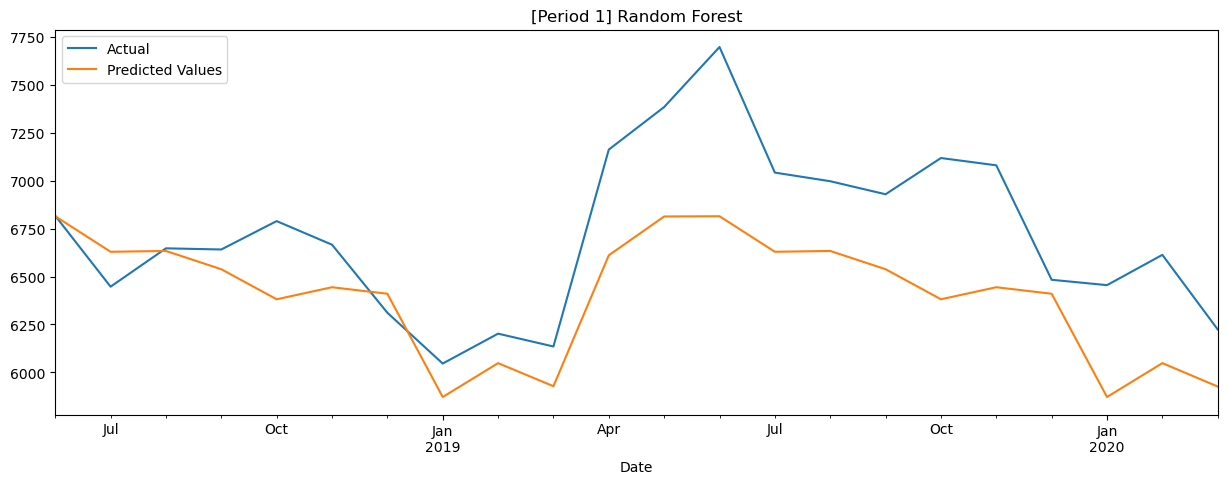

In [56]:
ax = testPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] RF Predictions"].plot(ax=ax, label="Predicted Values")

plt.title("[Period 1] Random Forest")
plt.legend(loc="upper left")

plt.show()

***
### PERIOD 2: Pandemic
***

#### Model Fitting

In [40]:
randomForestModel.fit(X_trainPan, y_trainPan)

/var/folders/s9/xh4rrhqs4pz887k97zl69jw00000gn/T/ipykernel_34917/1907178356.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForestModel.fit(X_trainPan, y_trainPan)


RandomForestRegressor(max_features=4, n_estimators=10000, random_state=1)

#### Predictions

In [41]:
predRandomForest_pan = randomForestModel.predict(X_testPan)

# Make a new column in test dataframe: predictions for period 2
testPan["[Period 2] RF Predictions"] = predRandomForest_pan

#### Data Visualization

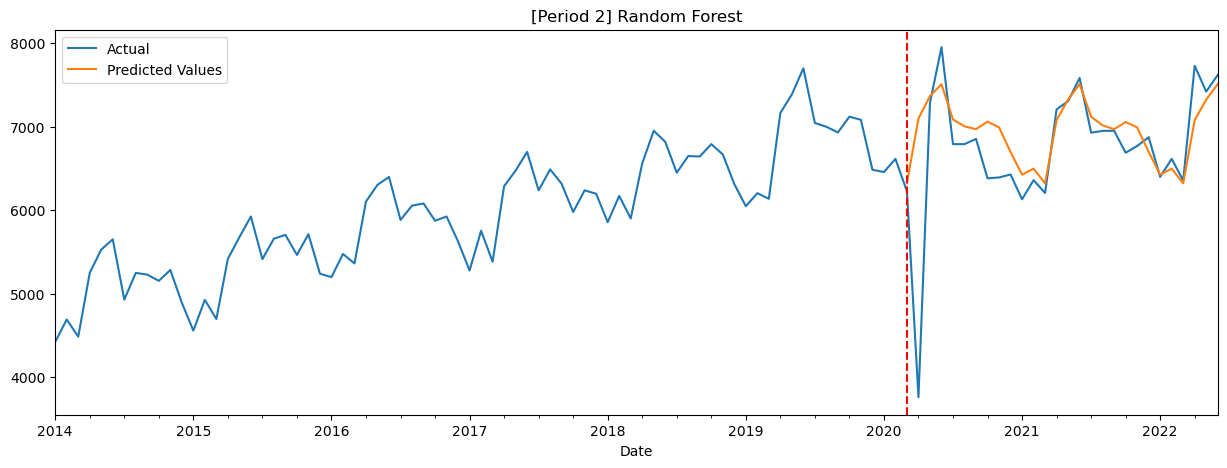

In [42]:
ax = totalPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] RF Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 2] Random Forest")
plt.legend(loc="upper left")

plt.show()

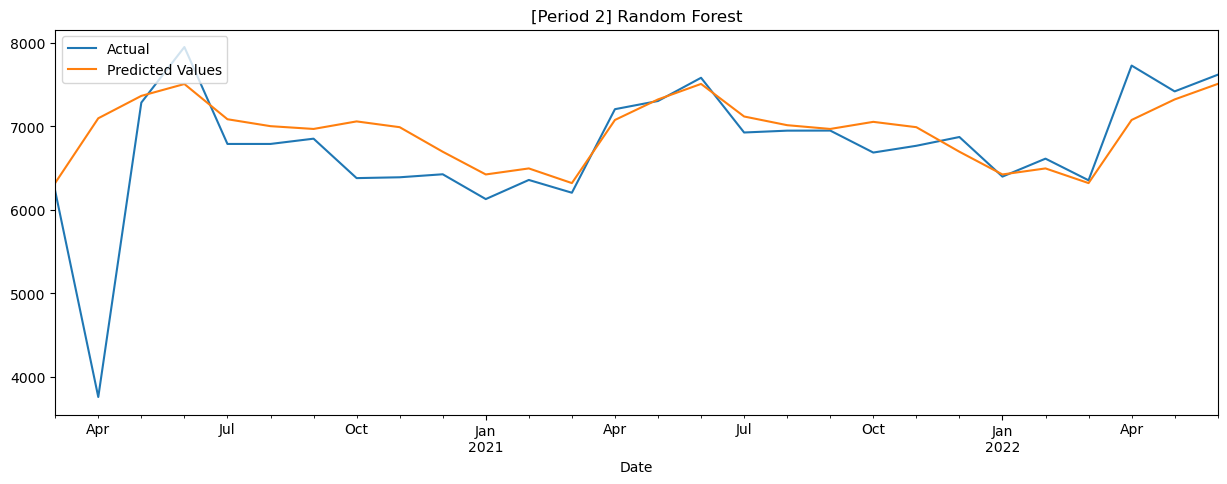

In [55]:
ax = testPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] RF Predictions"].plot(ax=ax, label="Predicted Values")

plt.title("[Period 2] Random Forest")
plt.legend(loc="upper left")

plt.show()

***
### Evaluation Metric
***

#### Root Mean Square Error (RMSE)

In [44]:
rmsePre_RF = mean_squared_error(y_testPre, predRandomForest_pre, squared=False)
rmsePan_RF = mean_squared_error(y_testPan, predRandomForest_pan, squared=False)

print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(1, rmsePre_RF))
print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(2, rmsePan_RF))

The Root Mean Square Error (RMSE) of Period 1 is 422.73690597202904
The Root Mean Square Error (RMSE) of Period 2 is 687.6654615882316


#### Mean Absolute Percentage Error (MAPE)

In [45]:
mapePre_RF = mean_absolute_percentage_error(y_testPre, predRandomForest_pre)
mapePan_RF = mean_absolute_percentage_error(y_testPan, predRandomForest_pan)

print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(1, mapePre_RF))
print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(2, mapePan_RF))

The Mean Absolute Percentage Error (MAPE) of Period 1 is 0.050313804978411335
The Mean Absolute Percentage Error (MAPE) of Period 2 is 0.06123184926393242


***
## Linear Regression
***

In [29]:
linearReg = LinearRegression()

***
### PERIOD 1: Pre-Pandemic
***

#### Model Fitting

In [30]:
linearReg.fit(X_trainPre, y_trainPre)

LinearRegression()

#### Predictions

In [25]:
predlinearReg_pre = linearReg.predict(X_testPre)

# Make a new column in test dataframe: predictions for period 1
testPre["[Period 1] Linear Regression Predictions"] = predlinearReg_pre

#### Data Visualization

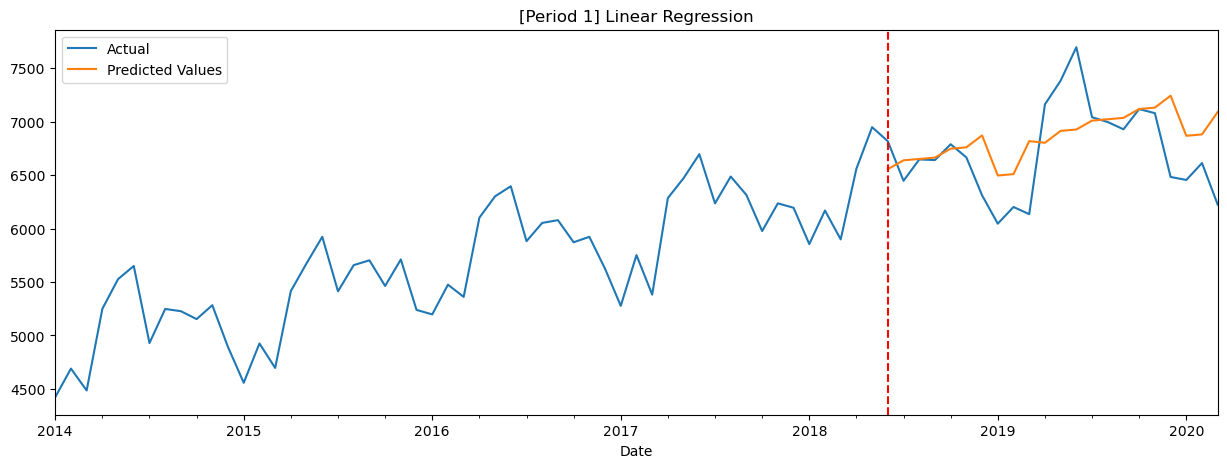

In [26]:
ax = totalPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] Linear Regression Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2018-06-01', color='red', ls='--')

plt.title("[Period 1] Linear Regression")
plt.legend(loc="upper left")

plt.show()

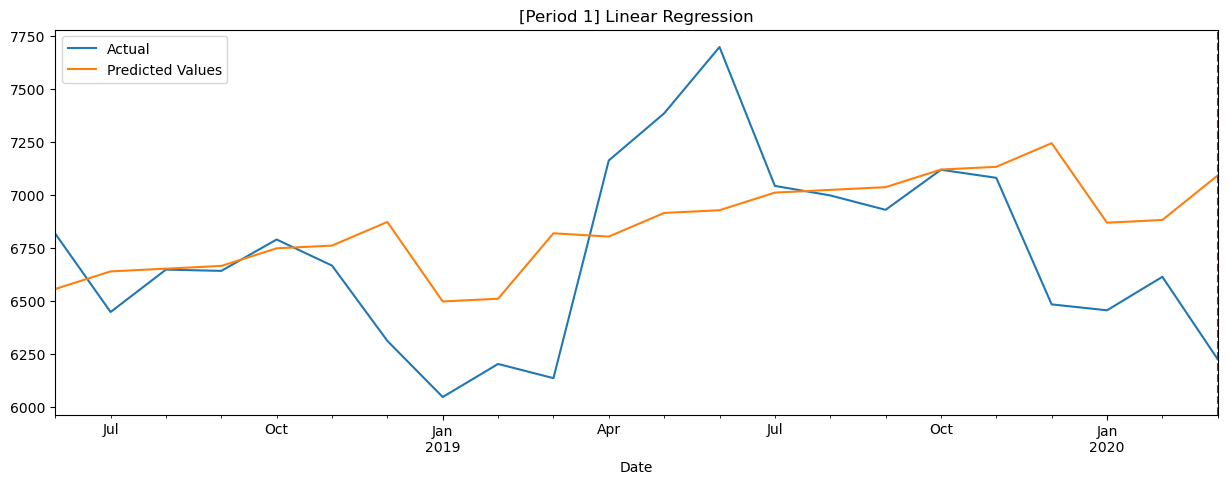

In [28]:
ax = testPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] Linear Regression Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 1] Linear Regression")
plt.legend(loc="upper left")

plt.show()

***
### PERIOD 2: Pandemic
***

#### Model Fitting

In [32]:
linearReg.fit(X_trainPan, y_trainPan)

LinearRegression()

#### Predictions

In [33]:
predlinearReg_pan = linearReg.predict(X_testPan)

# Make a new column in test dataframe: predictions for period 2
testPan["[Period 2] Linear Regression Predictions"] = predlinearReg_pan

#### Data Visualization

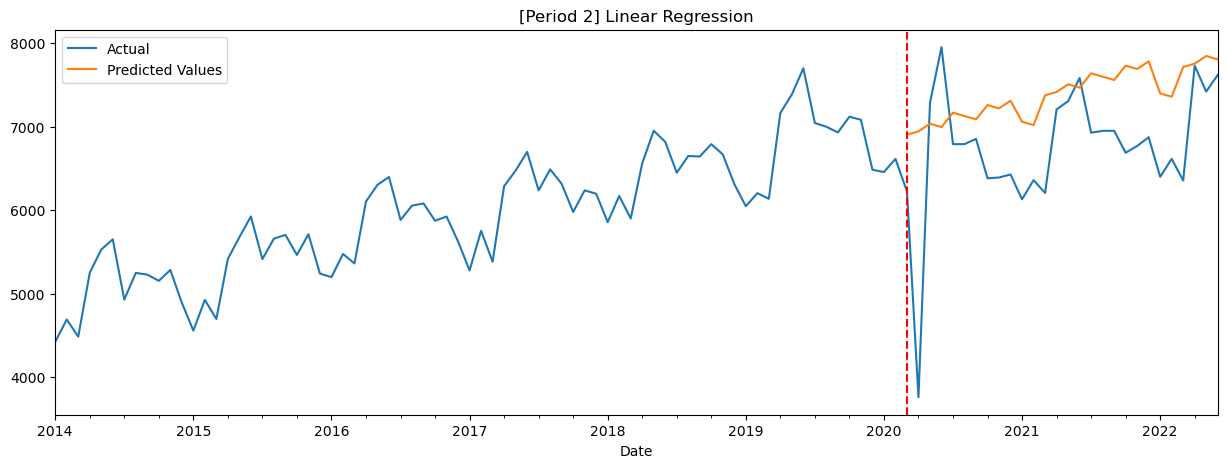

In [34]:
ax = totalPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] Linear Regression Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 2] Linear Regression")
plt.legend(loc="upper left")

plt.show()

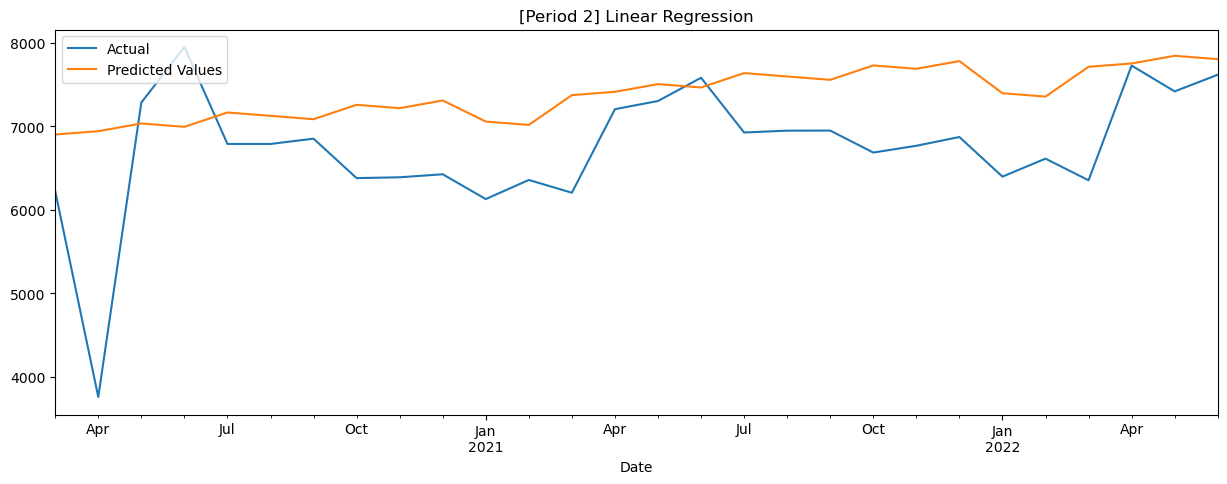

In [36]:
ax = testPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] Linear Regression Predictions"].plot(ax=ax, label="Predicted Values")

plt.title("[Period 2] Linear Regression")
plt.legend(loc="upper left")

plt.show()

***
### Evaluation Metric
***

#### Root Mean Square Error (RMSE)

In [40]:
rmsePre_LR = mean_squared_error(y_testPre, predlinearReg_pre, squared=False)
rmsePan_LR = mean_squared_error(y_testPan, predlinearReg_pan, squared=False)

print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(1, rmsePre_LR))
print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(2, rmsePan_LR))

The Root Mean Square Error (RMSE) of Period 1 is 411.5781320804336
The Root Mean Square Error (RMSE) of Period 2 is 935.8795990021758


#### Mean Absolute Percentage Error (MAPE)

In [38]:
mapePre_LR = mean_absolute_percentage_error(y_testPre, predlinearReg_pre)
mapePan_LR = mean_absolute_percentage_error(y_testPan, predlinearReg_pan)

print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(1, mapePre_LR))
print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(2, mapePan_LR))

The Mean Absolute Percentage Error (MAPE) of Period 1 is 0.04650345127562176
The Mean Absolute Percentage Error (MAPE) of Period 2 is 0.12297187275276034


***
## Support Vector Regression (SVR)
***

In [46]:
supportVectorReg = SVR(kernel='rbf', C=1000000, epsilon=10)

***
### PERIOD 1: Pre-Pandemic
***

#### Model Fitting

In [47]:
supportVectorReg.fit(X_trainPre, y_trainPre)

/Users/errutorculas/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000000, epsilon=10)

#### Predictions

In [48]:
predSVR_pre = supportVectorReg.predict(X_testPre)

# Make a new column in test dataframe: predictions for period 1
testPre["[Period 1] SVR Predictions"] = predSVR_pre

#### Data Visualization

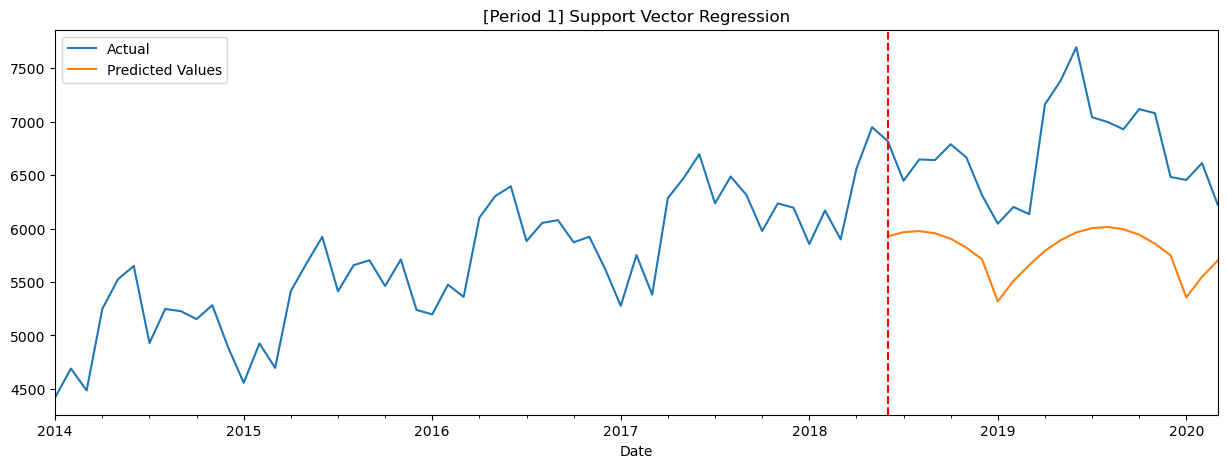

In [49]:
ax = totalPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] SVR Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2018-06-01', color='red', ls='--')

plt.title("[Period 1] Support Vector Regression")
plt.legend(loc="upper left")

plt.show()

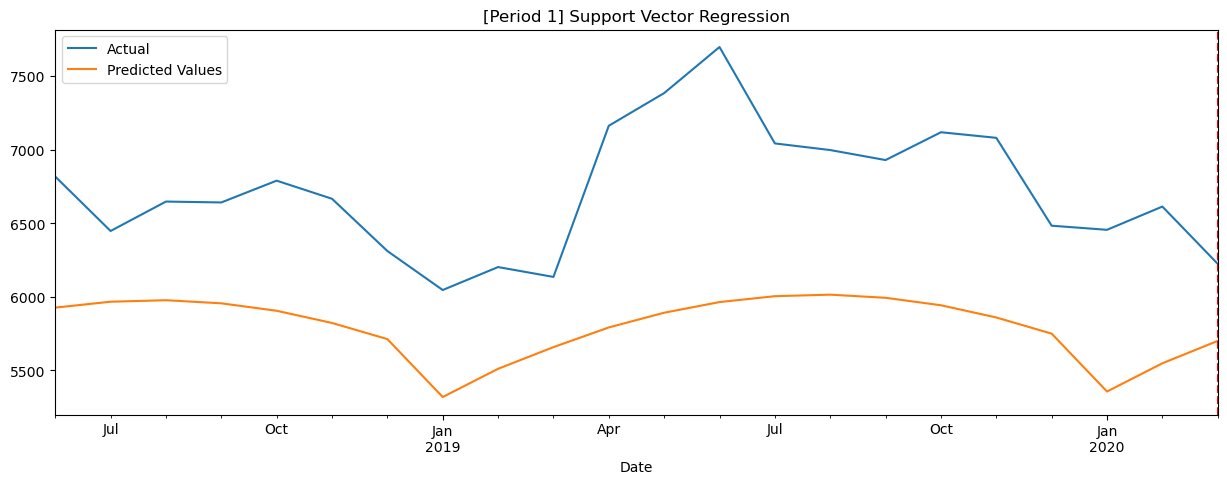

In [50]:
ax = testPre['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPre["[Period 1] SVR Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 1] Support Vector Regression")
plt.legend(loc="upper left")

plt.show()

***
### PERIOD 2: Pandemic
***

#### Model Fitting

In [29]:
supportVectorReg.fit(X_trainPan, y_trainPan)

/Users/errutorculas/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000000, epsilon=10)

#### Predictions

In [52]:
predSVR_pan = supportVectorReg.predict(X_testPan)

# Make a new column in test dataframe: predictions for period 2
testPan["[Period 2] SVR Predictions"] = predSVR_pan

#### Data Visualization

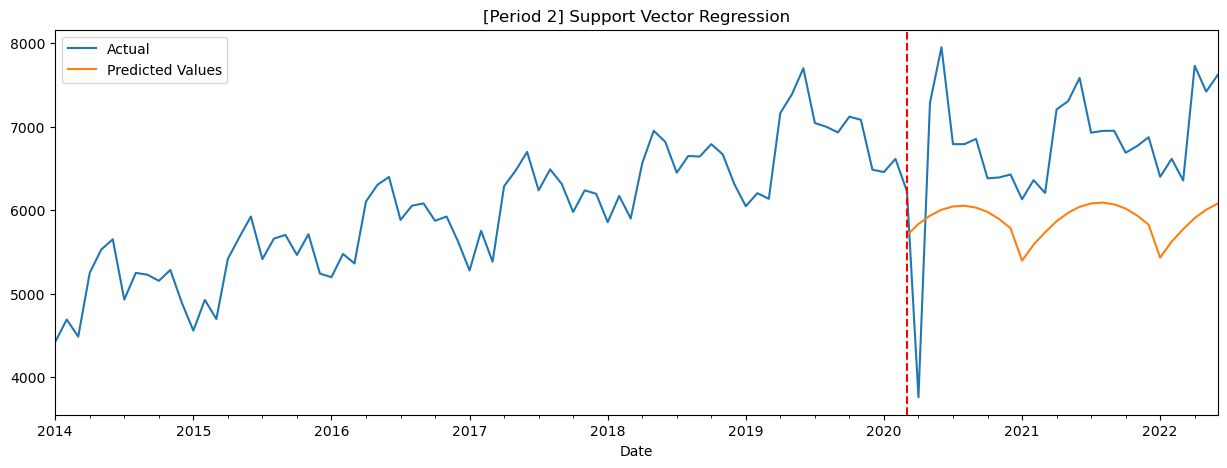

In [53]:
ax = totalPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] SVR Predictions"].plot(ax=ax, label="Predicted Values")
ax.axvline('2020-03-01', color='red', ls='--')

plt.title("[Period 2] Support Vector Regression")
plt.legend(loc="upper left")

plt.show()

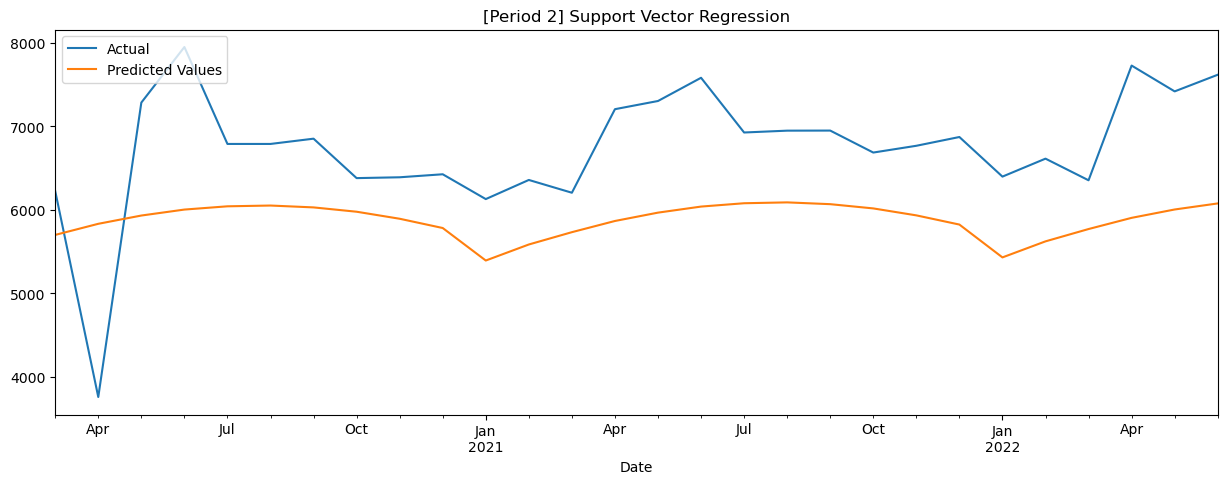

In [54]:
ax = testPan['Total Energy Consumption (in GWh)'].plot(figsize=(15, 5), label="Actual")
testPan["[Period 2] SVR Predictions"].plot(ax=ax, label="Predicted Values")

plt.title("[Period 2] Support Vector Regression")
plt.legend(loc="upper left")

plt.show()

***
### Evaluation Metric
***

#### Root Mean Square Error (RMSE)

In [57]:
rmsePre_SVR = mean_squared_error(y_testPre, predSVR_pre, squared=False)
rmsePan_SVR = mean_squared_error(y_testPan, predSVR_pan, squared=False)

print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(1, rmsePre_SVR))
print('The Root Mean Square Error (RMSE) of Period {} is {}'.format(2, rmsePan_SVR))

The Root Mean Square Error (RMSE) of Period 1 is 978.8414895477383
The Root Mean Square Error (RMSE) of Period 2 is 1110.2003342544674


#### Mean Absolute Percentage Error (MAPE)

In [58]:
mapePre_SVR = mean_absolute_percentage_error(y_testPre, predSVR_pre)
mapePan_SVR = mean_absolute_percentage_error(y_testPan, predSVR_pan)

print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(1, mapePre_SVR))
print('The Mean Absolute Percentage Error (MAPE) of Period {} is {}'.format(2, mapePan_SVR))

The Mean Absolute Percentage Error (MAPE) of Period 1 is 0.1353514251920893
The Mean Absolute Percentage Error (MAPE) of Period 2 is 0.15372070950856884


***